## Import modules

In [1]:
import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'
# numpy is used for generating, storing, and plotting data
import numpy as np
# zfit will be used for the parameter estimation in the following
import zfit
import uproot
import pandas

# in order to visualise the results of the computation, we use matplotlib
import matplotlib as mpl
if os.path.exists('lhcbStylerc'):
    mpl.rc_file('lhcbStylerc') # some plotting presets i usually use, you can find them in the git-repo
import socket
#if 'jupyter-schmitse-' in socket.gethostname():
#    mpl.rcParams['text.usetex'] = False # no latex on binder
    
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.LHCb2)
#plt.rcParams['text.usetex'] = True
# for histograms boost has an easy api and is very fast
import hist
# for statistical distributions we can use a lot from scipy
from scipy import stats

### Open ntuple

In [2]:
branches_we_want = ["C_M","Xicc_M_DTF_Lc_PV","Pi_M","C_M_DTF_Xicc_PV","C_KaonDTF_C_M","Xicc_TMVA_BDTXicc","BDT","BDTG","MLP"] 

#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-WS-Run2-Lc-Loose-clone-duplicate-Loose-MVA.root"
with uproot.open(path) as file:
    Xiccp_WS = file['DecayTree']
    Xiccp_WS_Loose_data = Xiccp_WS.arrays(expressions = branches_we_want, library='pd')
    
  
    
#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-RS-Run2-Lc-Loose-clone-duplicate-Loose-MVA.root"
with uproot.open(path) as file:
    Xiccp_RS = file['DecayTree'] 
    Xiccp_RS_Loose_data = Xiccp_RS.arrays(expressions = branches_we_want, library='pd')
    
 

# TIGHT

#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-WS-Run2-Lc-Loose-clone-duplicate-Tight-MVA.root"
with uproot.open(path) as file:
    Xiccp_WS = file['DecayTree']
    Xiccp_WS_Tight_data = Xiccp_WS.arrays(expressions = branches_we_want, library='pd')
    
   
    
#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-RS-Run2-Lc-Loose-clone-duplicate-Tight-MVA.root"
with uproot.open(path) as file:
    Xiccp_RS = file['DecayTree']
    Xiccp_RS_Tight_data = Xiccp_RS.arrays(expressions = branches_we_want, library='pd')
    
 


## MC

In [3]:
pathOmega="/eos/lhcb/user/p/pgaigne/STEP3/Run2/Omegaccpst-MC-Run2-MCMatch-clone-duplicate.root"

thresholdOmega = 4115.1

pathXicc="/eos/lhcb/user/p/pgaigne/STEP3/Run2/Xiccpst-MC-Run2-MCMatch-clone-duplicate.root"
thresholdXicc = 3761


branches = ["Xicc_M_DTF_Lc_PV", "Lc_M", "Pi_ProbNNk", "Pi_ProbNNpi", "C_KaonDTF_K_PT", "Pi_PT", "Xicc_TMVA_BDTXicc", "C_TRUEP_E", "C_TRUEP_X", "C_TRUEP_Y", "C_TRUEP_Z"]
      


file =  uproot.open(pathXicc)
tree = file['DecayTree']
data_Xicc = tree.arrays( library='pd').reset_index(level=1, drop=True).drop_duplicates(subset=['C_ETA','C_LOKI_IPCHI2'])
file.close() 

In [4]:
zfit.settings.set_seed(1337)
gen = np.random.default_rng(seed=1337)

## Cut selection

In [5]:
Omega_SB_start, Omega_SB_end = 25, 40
Xi_SB_start, Xi_SB_end = 25, 40

# Omegaccp_WS_Loose_data_cut = Omegaccp_WS_Loose_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15")
Xiccp_WS_Loose_data_cut = Xiccp_WS_Loose_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15")
# Omegaccp_RS_Loose_data_cut = Omegaccp_RS_Loose_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15")
Xiccp_RS_Loose_data_cut = Xiccp_RS_Loose_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15")
# Omegaccp_SB_Loose_data_cut = Omegaccp_RS_Loose_data.query(f"((Xicc_M_DTF_Lc_PV<3621-{Omega_SB_start})&(Xicc_M_DTF_Lc_PV>3621-{Omega_SB_end}))|((Xicc_M_DTF_Lc_PV>3621+{Omega_SB_start})&(Xicc_M_DTF_Lc_PV<3621+{Omega_SB_end}))")
Xiccp_SB_Loose_data_cut = Xiccp_RS_Loose_data.query(f"((Xicc_M_DTF_Lc_PV<3621-{Xi_SB_start})&(Xicc_M_DTF_Lc_PV>3621-{Xi_SB_end}))|((Xicc_M_DTF_Lc_PV>3621+{Xi_SB_start})&(Xicc_M_DTF_Lc_PV<3621+{Xi_SB_end}))")


# Omegaccp_WS_Tight_data_cut = Omegaccp_WS_Tight_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & Xicc_TMVA_BDTXicc>0.17")
Xiccp_WS_Tight_data_cut = Xiccp_WS_Tight_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & Xicc_TMVA_BDTXicc>0.17")
# Omegaccp_RS_Tight_data_cut = Omegaccp_RS_Tight_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & Xicc_TMVA_BDTXicc>0.17")
Xiccp_RS_Tight_data_cut = Xiccp_RS_Tight_data.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & Xicc_TMVA_BDTXicc>0.17")
# Omegaccp_SB_Tight_data_cut = Omegaccp_RS_Tight_data.query(f"((Xicc_M_DTF_Lc_PV<3621-{Omega_SB_start})&(Xicc_M_DTF_Lc_PV>3621-{Omega_SB_end}))|((Xicc_M_DTF_Lc_PV>3621+{Omega_SB_start})&(Xicc_M_DTF_Lc_PV<3621+{Omega_SB_end}))")
Xiccp_SB_Tight_data_cut = Xiccp_RS_Tight_data.query(f"((Xicc_M_DTF_Lc_PV<3621-{Xi_SB_start})&(Xicc_M_DTF_Lc_PV>3621-{Xi_SB_end}))|((Xicc_M_DTF_Lc_PV>3621+{Xi_SB_start})&(Xicc_M_DTF_Lc_PV<3621+{Xi_SB_end}))")


In [6]:
# data_Omega_cut = data_Omega.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & abs(Lc_M-2288)<18 & Pi_ProbNNk>0.1 & C_KaonDTF_K_PT>200 & Xicc_TMVA_BDTXicc>0.07")

data_Xicc_cut = data_Xicc.query("abs(Xicc_M_DTF_Lc_PV-3621)<15 & abs(Lc_M-2288)<18  & Pi_ProbNNpi>0.1 & Pi_PT>200 & Xicc_TMVA_BDTXicc>0.07")

## Xiccp

### MC

In [7]:
mass = 3800

obs_min = -50
obs_max = +50
obs_bin_width = 1
obs_bin = int((obs_max-obs_min)/obs_bin_width)

# data = data_Xicc_cut.query(f"abs(C_M_DTF_Xicc_PV-{mass})<50").C_M_DTF_PV
Data = data_Xicc_cut.query(f"abs(C_M_DTF_PV-{mass})<50")

data = Data.C_M_DTF_PV-np.sqrt(Data.C_TRUEP_E**2-(Data.C_TRUEP_X**2+Data.C_TRUEP_Y**2+Data.C_TRUEP_Z**2))

In [8]:
# parameters for signal and background shapes
mu = zfit.Parameter("mu_", 0, -50, 50)
sigma1 = zfit.Parameter("sigma1", 1.5, 0.5, 50.)

sigma2 = zfit.Parameter("sigma2", 1.5, 1., 50.)
a1 = zfit.Parameter("alpha1",1.5,0.,10.)
a2 = zfit.Parameter("alpha2",6.5,0.,10.)
n1 = zfit.Parameter("n1",1.5,0.,15.)
n2 = zfit.Parameter("n2",1.5,0.,15.)
frac = zfit.Parameter("frac",0.3,0.,1.)

# using a dict for the params
def mult_dict(params):
    return np.sqrt(params["frac"] * params["sigma1"]**2 + (1-params["frac"]) * params["sigma2"]**2)

sigma = zfit.ComposedParameter('sigma', mult_dict, params={"sigma1": sigma1, "sigma2": sigma2, "frac": frac})

# yields for an extended fit
n_signal = zfit.Parameter('n_signal', 100, 0, 10000)

In [9]:
obs_bkg = zfit.Space('Observable with Background', limits=(obs_min, obs_max))





# create the pdfs with the extended term for the yields
gaussian = zfit.pdf.Gauss(obs=obs_bkg, mu=mu, sigma=sigma1, name='Gaussian')
doubleCB = zfit.pdf.DoubleCB(mu=mu, sigma=sigma2, alphal=a1, nl=n1, alphar=a2, nr=n2, obs=obs_bkg, name='DoubleCB')

model_sum = zfit.pdf.SumPDF([gaussian, doubleCB], fracs=[frac])

model_ext = doubleCB.create_extended(n_signal)



# build the model as the sum of the gaussian and the exponential functions
model = model_ext

In [10]:
data_all = data.to_numpy()

data_zfit = zfit.Data.from_numpy(obs=obs_bkg, array=data_all)

# loss function is now extended unbinned NLL
nll_ext = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data_zfit)

# the minimiser
minimiser = zfit.minimize.Minuit(mode=1)

### Minimization

In [14]:
# %%
result_ext = minimiser.minimize(nll_ext)
result_ext.hesse(name='minuit_hesse')
# result_ext.errors()
print(result_ext)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.physics.DoubleCB'>  params=[alpha1, alpha2, mu_, n1, n2, sigma2]] data=[<zfit.core.data.Data object at 0x7f8cb8de4bb0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ False   │ True        │ False            │ 6.8e-08 │ -28800.68   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name        value  (rounded)    at limit
--------  ------------------  ----------
n_signal                3918       False
mu_                  1.67698       False
sigma2               7.50376       False
alpha1               2.47818       False
n1                   2.62057       False
alpha2               8.73955       False
n2                   8.46656       False


In [15]:
muu = float(mu)
# mu_err = result_ext.hesse()[mu]['error']

sigma.read_value()

<tf.Tensor: shape=(), dtype=float64, numpy=6.331630350385753>

In [16]:
def plot_fit(dat: np.ndarray, basis: np.ndarray, model: np.ndarray, 
             obs: zfit.Space, nbins : int=obs_bin, smodel: np.ndarray=None,
             drawstyle: str='default', zmodel: zfit.pdf.BasePDF=None, title='LHCb 2016'):
    """
    quick plotting function to visualise data and model. 
    Takes:
     - dat: (array) the data that are fitted
     - basis: (array) the points at which the model is evaluated
     - model: (array) the model that describes the data
     - obs: (zfit Space) the space in which the model lives
     - nbins: (int) the number of bins for the data histogram
     - smodel: (array) uncertainty on model (not needed)
     - drawstyle: (str) the drawstyle of plt.plot
     - zmodel: (BasePDF) for drawing submodels
    Returns:
     - None
    """
    # for normalising the pdf, scaled pdf = pdf * yield * area / bins
    limits = obs.limits 
    area = obs.area().numpy()

    # data in histogram over the full observable space
    histo = hist.Hist(hist.axis.Regular(nbins, *limits))
    histo.fill(dat)

    # the figure with an errorbar for the data and a line for the model
    fig, ax = plt.subplots()
    art_data = ax.errorbar(histo.axes.centers[0], histo.values(), 
                           xerr=histo.axes.widths[0]/2,
                           yerr=np.sqrt(histo.values()), fmt='.', 
                           label='Data', color='black', zorder=10)
    art_model = ax.plot(basis, model * area/nbins, color='darkturquoise', 
                        label='Model', zorder=8, drawstyle=drawstyle)[0]
    
    # if we have the uncertainty on the model we draw it as contour
    # and update the artist for the legend to reflect on the new model
    if smodel is not None:
        _art = ax.fill_between(basis, (model+smodel)*area/nbins, 
                               (model-smodel)*area/nbins, color='darkturquoise', 
                               alpha=0.5, zorder=-2)
        art_model = (art_model, _art)

    # define artists and labels for the legend
    artists = [art_data, art_model]
    labels = ['Data', 'Model']
    # if we want to plot the submodels of our model, we can iterate through
    # all of them and evaluate them at our basis. We will not bootstrap
    # all of their shape uncertainties though, this is just an illustration
    if hasattr(zmodel, 'get_models'):
        nmodels = len(zmodel.get_models())
        cmap = plt.get_cmap('autumn') # you can choose whatever you like. 
        norm = mpl.colors.Normalize(0, nmodels) # create a norm for the cmap
        pdfs = [(m.pdf(basis)*n_signal*frac).numpy()*area/nbins
                for m, frac in zip(zmodel.pdfs, zmodel.params.values())]
        names = [m.name.replace('_extended','') for m in zmodel.get_models()]
        labels.extend(names)
        for mdex, pdf in enumerate(pdfs):
            artists.append(ax.plot(basis, pdf, color=cmap(norm(mdex)), 
                                   linestyle='--', zorder=-1)[0])
        
    
    #ax.set_xlabel('$m_{cand}(\Xi_{cc}^{++})[MeV/c^2]$')
    ax.set_xlabel('M$(\Xi_{cc}^{**+})[MeV/c^2]$')
    ax.set_ylabel(f'Events/( {obs_bin_width} MeV/$c^2$ )');
    
    textstr = '\n'.join((
    r'$\mu_m=%.2f $ MeV/$c^2$' % (float(mu)),
    r'$\sigma_m=%.2f $  MeV/$c^2$' % (float(sigma2)),
    r'$\alpha_1=%.2f $' % (float(a1)),
    r'$\alpha_2=%.2f $' % (float(a2)),
    r'$n_1=%.2f $' % (float(n1)),
    r'$n_2=%.2f $' % (float(n2))))
    ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=24,
        verticalalignment='top')
    
    # legend and axis labels
    ax.legend(artists, labels, loc='upper left', 
              title=title, title_fontsize=20)


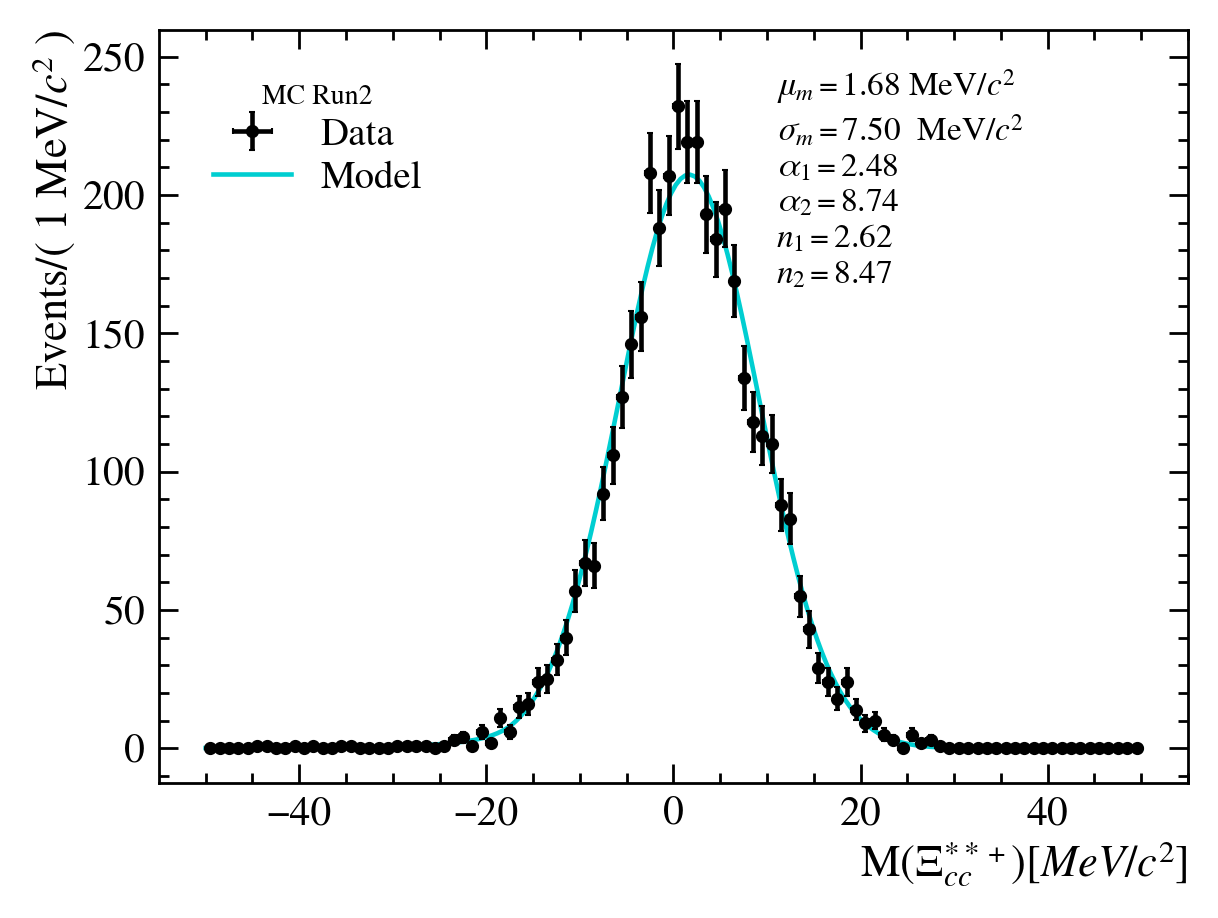

In [17]:
# the model as the sum of the individual pdfs
basis_pdf = np.linspace(obs_min, obs_max, 200)
model_pdf_np = model.pdf(basis_pdf).numpy() * (n_signal.numpy())

plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, zmodel=model, title=f'MC Run2')





## Background

### Minimization

## Plot the fitting result after cut

In [ ]:
fig, ax = plt.subplots()
ax.hist(data,range=[-50,50], bins=100, histtype ='step', label=r'TRUE_M')
# ax.set_xlabel(r'$\Delta BDT$')
ax.set_xlabel('M$(\Xi_{cc}^{**+})[MeV/c^2]$')
ax.set_ylabel(f'Events/( 2 MeV/$c^2$ )')
# plt.axvline(x=thresholdXicc,color='red')
ax.legend()

